In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import findspark
findspark.init()

import collections
import numpy as np
import pandas as pd
import datetime as dt
import os.path as osp
import matplotlib.pylab as plt
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.feature_selection as sfsel
import sklearn.tree as stree
import sklearn.ensemble as sensemble

from pyspark import keyword_only
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
sess = SparkSession.builder \
                   .master("local[*]") \
                   .config("spark.driver.memory", "32g") \
                   .getOrCreate()

In [3]:
test_df = sess.read.parquet("./stgt_sensors_with_date_geo_dwd_series.parquet/")
test_df.printSchema()
print(test_df.count())

root
 |-- hash: string (nullable = true)
 |-- start_year: integer (nullable = true)
 |-- weekend: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- holiday: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- day_of_week: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- day_num: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- time_num: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- temperature: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dwd_temperature: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- humidity: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dwd_precipitation_height: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- pressure: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dwd_wind_spe

In [4]:
test_df = test_df.withColumn("N_P1", size("P1")) \
                 .withColumn("N_temp", size("temperature")) \
                 .withColumn("N_dwd_temperature", size("dwd_temperature")) \
                 .where("N_P1 > %d" % 1e4)

In [5]:
test_df.select("hash").limit(10).toPandas()

,hash
0,u0wsyx2s1j08
1,u0wt2ryn72xj
2,u0wt3q71zdcj
3,u0wt5xnbyfmh
4,u0wkx07nkxj7
5,u0wmj205mnxm
6,u0wmp82r05e0
7,u0wmr07cegr1
8,u0wt17ksq4hs
9,u0wt2mcn0q57


In [6]:
def extract_to_vector(row, colname):
    return np.array(row[colname].values[0])

def row_to_frame(row):
    cols = row.columns.difference(('hash', 'start_year', 'pressure', 'N_P1', 'N_temp', 'N_dwd_temperature'))
    data = dict([(c, extract_to_vector(row, c)) for c in cols])
    return pd.DataFrame.from_dict(data)
  
def add_lag_features(df, col, lags=[48, 96, 128, 196]):
    inp = df[col]
    for l in lags:
        new_col = "%s_lag%d" % (col, l)
        df[new_col] = inp.shift(l)
    return df
    
def impute_and_scale(df, feature_suffix="feat"):
    for col in df.columns:
        try:
            new_col = "%s_%s" % (col, feature_suffix)
            imp = prep.Imputer(missing_values='NaN', strategy='mean', axis=0)
            scal = prep.RobustScaler()
            inp = np.atleast_2d(df[col].values).T
            outp = scal.fit_transform(imp.fit_transform(inp))
            df[new_col] = outp.ravel()
        except Exception as ex:
            print("Error '%s' during processing of col '%s'" % (ex, col))
    return df

def row_df_for_geohashes(series_df, hashes):
    pd_df = series_df.where(col("hash").isin(hashes)).toPandas()
    
    row_dfs = []
    for geohash in hashes:
        row = pd_df[pd_df["hash"] == geohash]
        row_dfs.append(impute_and_scale(add_lag_features(row_to_frame(row), "P1")))
    
    return pd.concat(row_dfs)

In [9]:
row_df = row_df_for_geohashes(test_df, ["u0wt3q71zdcj", "u0wt17ksq4hs", "u0wt2mcn0q57"])
row_df

,P1,P2,day_num,day_of_week,dwd_clouds,dwd_precipitation_height,dwd_sun,dwd_temperature,dwd_wind_direction,dwd_wind_speed,...,dwd_wind_speed_feat,holiday_feat,humidity_feat,temperature_feat,time_num_feat,weekend_feat,P1_lag48_feat,P1_lag96_feat,P1_lag128_feat,P1_lag196_feat
0,NaN,NaN,0.643601,4,8.0,0.0,0.0,3.5,130.0,3.1,...,0.222222,0.0,-0.153340,-0.694708,6.803069e-16,0.0,0.714939,0.709252,0.705904,0.699064
1,37.551111,17.054444,0.645089,4,8.0,0.0,0.0,3.5,130.0,3.1,...,0.222222,0.0,-0.160412,-0.698779,2.127660e-02,0.0,0.714939,0.709252,0.705904,0.699064
2,39.416316,17.901053,0.646577,4,8.0,0.0,0.0,3.5,130.0,3.1,...,0.222222,0.0,-0.154333,-0.686115,4.255319e-02,0.0,0.714939,0.709252,0.705904,0.699064
3,39.406429,18.025000,0.648065,4,8.0,0.0,0.0,3.5,130.0,3.1,...,0.222222,0.0,-0.155921,-0.671913,6.382979e-02,0.0,0.714939,0.709252,0.705904,0.699064
4,38.812500,18.065000,0.649554,4,8.0,0.0,0.0,3.8,110.0,2.9,...,0.111111,0.0,-0.189897,-0.606965,8.510638e-02,0.0,0.714939,0.709252,0.705904,0.699064
5,42.349333,19.815333,0.651042,4,8.0,0.0,0.0,3.8,110.0,2.9,...,0.111111,0.0,-0.211302,-0.588331,1.063830e-01,0.0,0.714939,0.709252,0.705904,0.699064
6,39.523077,19.305385,0.652530,4,8.0,0.0,0.0,3.8,110.0,2.9,...,0.111111,0.0,-0.225358,-0.533921,1.276596e-01,0.0,0.714939,0.709252,0.705904,0.699064
7,41.977857,20.162857,0.654018,4,8.0,0.0,0.0,3.8,110.0,2.9,...,0.111111,0.0,-0.253086,-0.468792,1.489362e-01,0.0,0.714939,0.709252,0.705904,0.699064
8,39.542609,20.550000,0.655506,4,7.0,0.0,38.0,4.4,120.0,1.9,...,-0.444444,0.0,-0.412678,-0.170828,1.702128e-01,0.0,0.714939,0.709252,0.705904,0.699064
9,36.591111,20.382222,0.656994,4,7.0,0.0,38.0,4.4,120.0,1.9,...,-0.444444,0.0,-0.612988,0.128053,1.914894e-01,0.0,0.714939,0.709252,0.705904,0.699064


In [10]:
row_df[[c for c in row_df.columns if c.endswith("_feat")]].isna().any()

P1_feat                          False
P2_feat                          False
day_num_feat                     False
day_of_week_feat                 False
dwd_clouds_feat                  False
dwd_precipitation_height_feat    False
dwd_sun_feat                     False
dwd_temperature_feat             False
dwd_wind_direction_feat          False
dwd_wind_speed_feat              False
holiday_feat                     False
humidity_feat                    False
temperature_feat                 False
time_num_feat                    False
weekend_feat                     False
P1_lag48_feat                    False
P1_lag96_feat                    False
P1_lag128_feat                   False
P1_lag196_feat                   False
dtype: bool

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))

axs[0].scatter(np.arange(len(row_df)), row_df["P1"].values, marker='.', c='blue')
axs[0].scatter(np.arange(len(row_df)), row_df["P2"].values, marker='.', c='darkblue')
axs[0].set_ylim([0, 200])
axs[0].legend(["P1", "P2"])
axs[0].set_title("Dust (Unscaled)")

axs[1].scatter(np.arange(len(row_df)), row_df["temperature"].values, marker='.', c='red')
axs[1].scatter(np.arange(len(row_df)), row_df["dwd_temperature"].values, marker='.', c='darkred')
axs[1].set_ylim([-30, 50])
axs[1].legend(["Temp.", "DWD Temp."])
axs[1].set_title("Temperatures (Unscaled)")

axs[2].scatter(np.arange(len(row_df)), row_df["dwd_precipitation_height"].values, marker='.', c='green')
axs[2].scatter(np.arange(len(row_df)), row_df["humidity"].values, marker='.', c='lightgreen')
axs[2].legend(["Perticipation.", "Humidity"])
axs[2].set_title("Water (Unscaled)")

axs[3].scatter(np.arange(len(row_df)), row_df["dwd_wind_speed"].values, marker='.', c='magenta')
axs[3].scatter(np.arange(len(row_df)), row_df["dwd_wind_direction"].values, marker='.', c='cyan')
axs[3].legend(["Wind Speed", "Wind Direction"])
axs[3].set_title("Air (Unscaled)")

axs[4].scatter(np.arange(len(row_df)), row_df["dwd_sun"].values, marker='.', c='yellow')
axs[4].scatter(np.arange(len(row_df)), row_df["dwd_clouds"].values, marker='.', c='gold')
axs[4].legend(["Sun Hours", "Clouds"])
axs[4].set_title("Fire (Unscaled)")

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))

axs[0].scatter(np.arange(len(row_df)), row_df["P1_feat"].values, marker='.', c='blue')
axs[0].scatter(np.arange(len(row_df)), row_df["P2_feat"].values, marker='.', c='darkblue')
axs[0].set_ylim([0, 10])
axs[0].legend(["P1", "P2"])
axs[0].set_title("Dust (Unscaled)")

axs[1].scatter(np.arange(len(row_df)), row_df["temperature_feat"].values, marker='.', c='red')
axs[1].scatter(np.arange(len(row_df)), row_df["dwd_temperature_feat"].values, marker='.', c='darkred')
axs[1].legend(["Temp.", "DWD Temp."])
axs[1].set_ylim([-2, 2])
axs[1].set_title("Temperatures (Unscaled)")

axs[2].scatter(np.arange(len(row_df)), row_df["dwd_precipitation_height_feat"].values, marker='.', c='green')
axs[2].scatter(np.arange(len(row_df)), row_df["humidity_feat"].values, marker='.', c='lightgreen')
axs[2].legend(["Perticipation.", "Humidity"])
axs[2].set_title("Water")

axs[3].scatter(np.arange(len(row_df)), row_df["dwd_wind_speed_feat"].values, marker='.', c='magenta')
axs[3].scatter(np.arange(len(row_df)), row_df["dwd_wind_direction_feat"].values, marker='.', c='cyan')
axs[3].legend(["Wind Speed", "Wind Direction"])
axs[3].set_title("Air")

axs[4].scatter(np.arange(len(row_df)), row_df["dwd_sun_feat"].values, marker='.', c='yellow')
axs[4].scatter(np.arange(len(row_df)), row_df["dwd_clouds_feat"].values, marker='.', c='gold')
axs[4].legend(["Sun Hours", "Clouds"])
axs[4].set_title("Fire")

In [11]:
feat_cols = list(set([c for c in row_df.columns if c.endswith("_feat")]).difference(("P1_feat", "P2_feat")))
tgt_col = "P1_feat"
X = row_df[feat_cols].values
y = row_df[tgt_col].values
print(X.shape)
print(y.shape)

(61568, 17)
(61568,)


In [12]:
sel = sfsel.SelectKBest(sfsel.mutual_info_regression, k=2)
sel.fit(X, y)

SelectKBest(k=2,
      score_func=<function mutual_info_regression at 0x7f0d09d07598>)

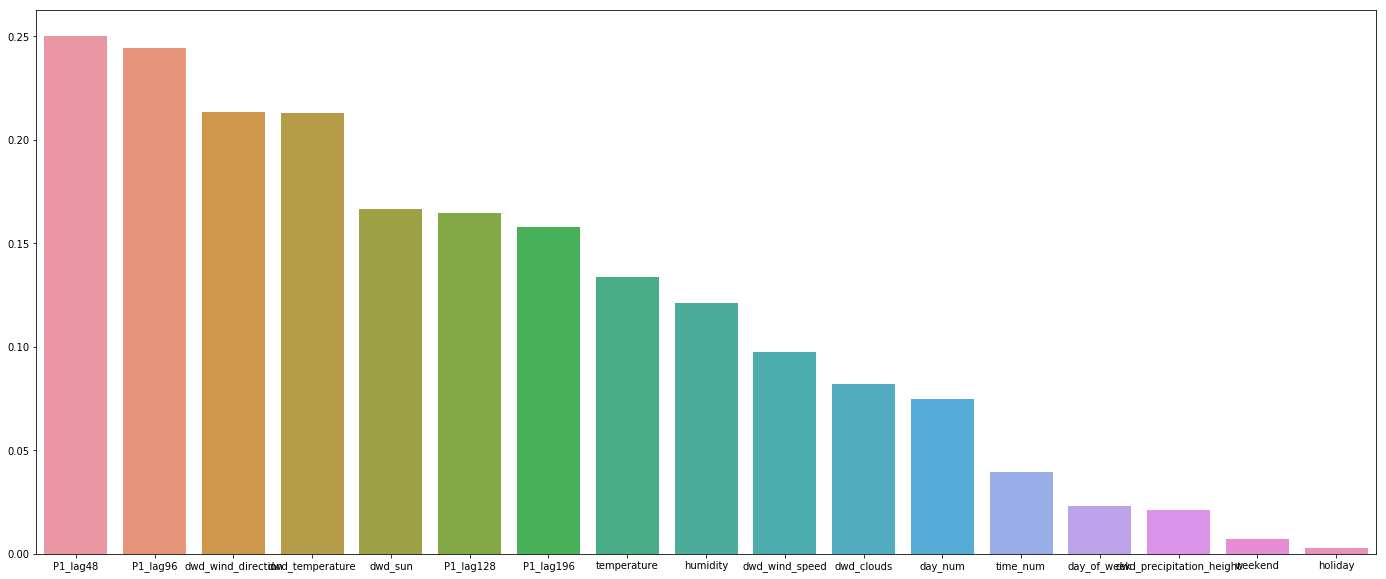

In [15]:
def plot_feat_importance(feat_cols, scores):
    score_vals = dict(zip([c.replace("_feat", "") for c in feat_cols], scores))
    score_vals = collections.OrderedDict([(k, score_vals[k]) for k in sorted(score_vals, key=score_vals.get, reverse=True)])

    plt.figure(figsize=(24, 10))
    sns.barplot(list(score_vals.keys()), list(score_vals.values()))

plot_feat_importance(feat_cols, sel.scores_)

In [16]:
rng = np.random.RandomState(42)
regr = sensemble.AdaBoostRegressor(stree.DecisionTreeRegressor(max_depth=12), n_estimators=100, random_state=rng)
regr.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=<mtrand.RandomState object at 0x7f0d088b8750>)

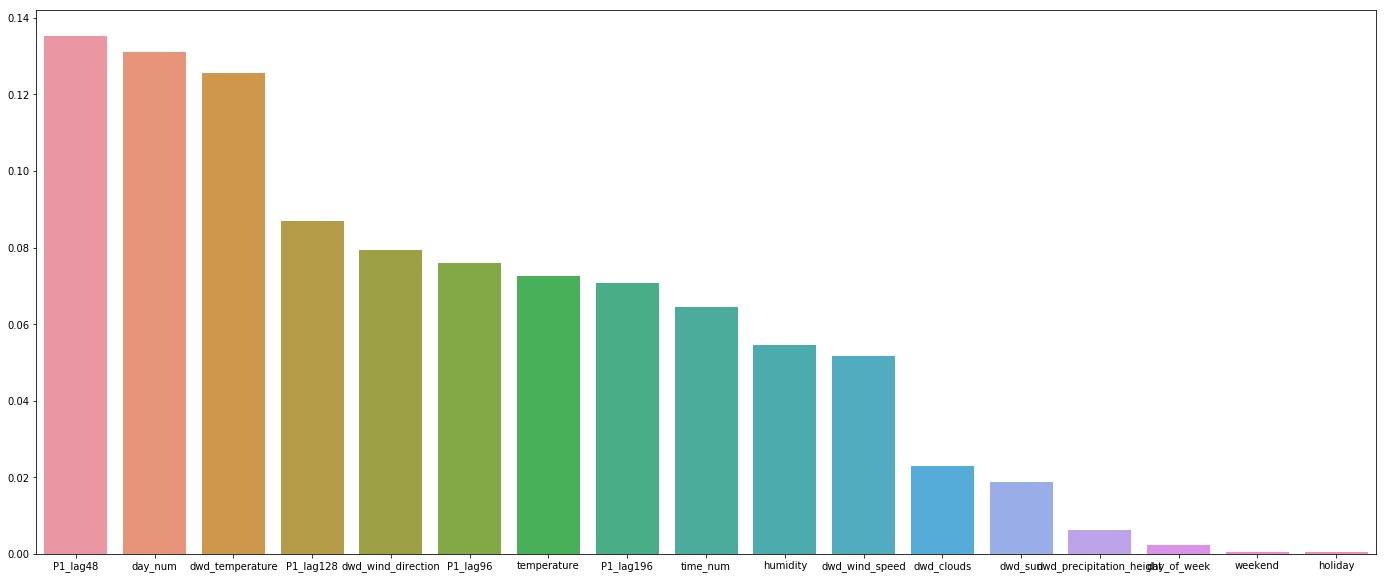

In [17]:
plot_feat_importance(feat_cols, regr.feature_importances_)

Text(0.5,1,'Dust Prediction')

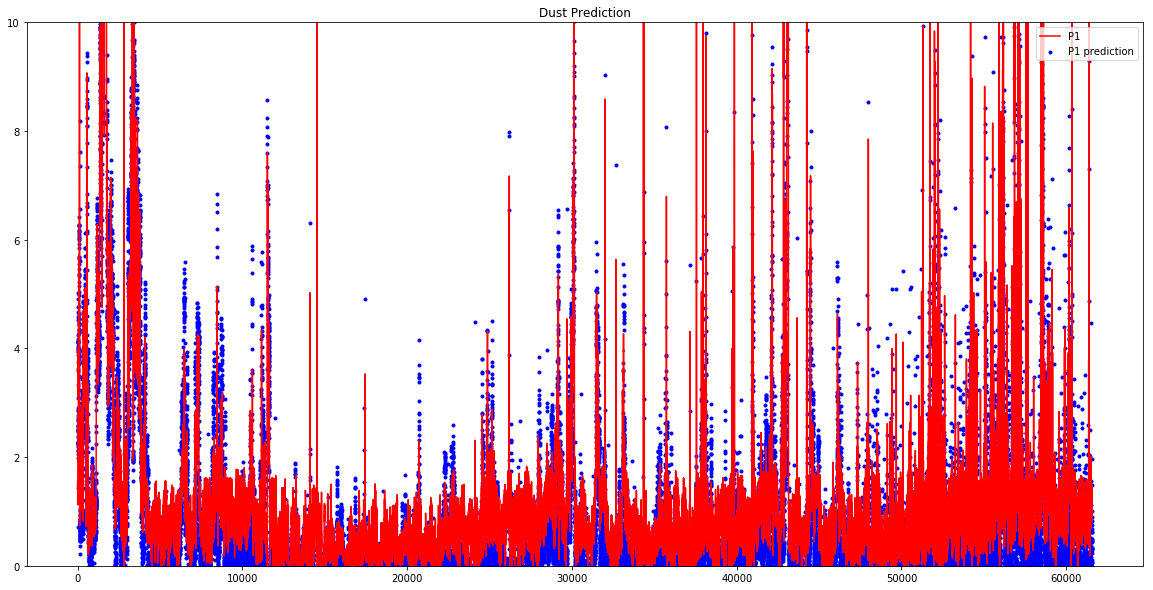

In [18]:
y_star = regr.predict(X)

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(np.arange(len(row_df)), row_df["P1_feat"].values, marker='.', c='blue')
ax.plot(np.arange(len(row_df)), y_star, c='red')
ax.set_ylim([0, 10])
ax.legend(["P1", "P1 prediction"])
ax.set_title("Dust Prediction")

In [19]:
print(y_star.shape)
print(y.shape)

(61568,)
(61568,)


In [27]:
np.sqrt(np.mean(np.power(y_star - y, 2)))

0.8358738223104336